In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
import shutil
import os

import tensorflow as tf
import tensorflow.compat.v1 as tfv1
from tensorflow.keras.utils import Progbar

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

from IPython.display import display

In [2]:
# tfv1.disable_v2_behavior()

In [3]:
def read_data(dataset=None, filename=None):
    if dataset is not None:
        if not isinstance(dataset, pd.DataFrame):
            raise TypeError("Data must be an instance of pd.DataFrame")
            
    elif filename is not None:
        dataset = pd.read_csv(filename)
        
    else:
        raise ValueError("No data passed (dataset or filename can't be None)")
        
    dataset.columns = dataset.columns.str.lower()
    
    for column in dataset.columns:
        if column == "date" or dataset[column].dtype != "object": 
            try:
                dataset[column] = pd.to_numeric(dataset[column])

            except ValueError:
                dataset[column] = pd.to_datetime(dataset[column])

            except Exception:
                pass

    return dataset

def remove_dir(path_from_root):
    """remove directories"""
    shutil.rmtree(path_from_root, ignore_errors=True)
    
    
def make_dir_if_not_exists(path_from_root):
    '''creates directory if not exists'''
    
    if not os.path.exists(path_from_root):
        os.makedirs(path_from_root)

In [4]:
def handle_missing_values(data, threshold=0.7):
    #Dropping columns with missing value rate higher than threshold
    data = data[data.columns[data.isnull().mean() < threshold]]

    #Dropping rows with missing value rate higher than threshold
    data = data.loc[data.isnull().mean(axis=1) < threshold]
        
    # last observed carries forward
    data.fillna(method='ffill', inplace=True)

    # fill forward
    data.fillna(method='bfill', inplace=True)

    # filling missing values with medians of the columns
    data.fillna(data.median(), inplace=True)
    
    return data


def handle_outliers(data):
    #Dropping the outlier rows with Percentiles
    upper_lim = data.quantile(.95)
    lower_lim = data.quantile(.05)

    return data[(data < upper_lim) & (data > lower_lim)]


def log_transform(data):
    #Note that the values are different
    min_value = data.min()
    
    return np.log(data - min_value + 1), min_value
    

def inverse_log_transform(data, min_value):
    return (np.exp(data) + min_value) - 1


def scale_transform(data, scaler):    
    return scaler.transform(data), scaler


def inverse_scale_transform(data, scaler):
    return scaler.inverse_transform(data)


def get_numeric_columns(data):
    data = data[data.dtypes[data.dtypes != "object"].index]
    return data.dtypes[data.dtypes != "datetime64[ns]"].index

def feature_importance(data, target, threshold=0.3):
    numeric_feats = list(get_numeric_columns(data))
    
    imp_feats = list()
    cormat = data[numeric_feats].corr().fillna(0)
    
    """get target index for feature extraction"""
    target_idx = cormat.columns.get_loc(target)
    
    
    for feat in numeric_feats:
        try:
            if cormat[feat][target_idx] > threshold:
                imp_feats.append(feat)
                
        except Exception:
            pass
        
    imp_feats.remove(target)    
    return data[imp_feats + [target]]


def split(data, train_ratio):
    '''split into training and testing data sets'''

    # num of rows in data
    rows = data.shape[0]

    # training parameters
    split_point = int(train_ratio * rows)

    # split into two dataframes
    data_train = data.iloc[:split_point, :]
    data_test = data.iloc[split_point:, :]

    return data_train, data_test

def construct_label(data, is_multi_variant, look_back):
    '''appends the label column by shifting it down (1 day ahead)'''
    x, y = list(), list()
    
    for i in range(len(data)):
        end_start = i + look_back
        
        if end_start >= len(data):
            break
        
        if is_multi_variant:
            x.append(data[i:end_start, :])
        else:
            x.append(data[i:end_start, -1])
            
        y.append(data[end_start, -1])
        
        end_start += 1
    
    return np.array(x), np.array(y).reshape(-1, 1)


def scale_transform(x, y, test_x=None, test_y=None):
    '''scales data using sklearn MinMaxScaler'''
    if x.ndim > 2:
        scalers = {}
        for i in range(x.shape[1]):
            scalers[i] = MinMaxScaler()
            x[:, i, :] = scalers[i].fit_transform(x[:, i, :]) 
        
        if test_x is not None and test_y is not None:
            for i in range(test_x.shape[1]):
                test_x[:, i, :] = scalers[i].transform(test_x[:, i, :])
                
    else:
        scaler_x = MinMaxScaler()
        scaler_x.fit(x)
        
        x = scaler_x.transform(x)
        
        if test_x is not None and test_y is not None:
            test_x = scaler_x.transform(test_x)
    
    scaler_y = MinMaxScaler()
    
    scaler_y.fit(y)
    y = scaler_y.transform(y)
    
    
    if test_x is not None and test_y is not None:
        test_y = scaler_y.transform(test_y)
        
        return x, y, test_x, test_y
    
    return x, y

In [5]:
def preprocess(target, output_path, look_back, input_path=None, train_ratio=0.7, validation_ratio=None, is_multi_variant=True, normalize=False, scale=True):
    dataset = read_data(filename=input_path)
    dataset = handle_missing_values(data=dataset)
    
    if is_multi_variant: # multivariate forecasting technique
        dataset = feature_importance(dataset, target)
        
    else: # univariate forecasting technique
        dataset = dataset[[target]]
    
    # split into training and testing
    train_data, test_data = split(dataset, train_ratio)
    
    if validation_ratio:
        train_data, val_data = split(train_data, validation_ratio)
        x_val, y_val = construct_label(data=val_data.values, look_back=look_back, is_multi_variant=is_multi_variant)
    
    # construct label
    x_train, y_train = construct_label(data=train_data.values, look_back=look_back, is_multi_variant=is_multi_variant)
    x_test, y_test = construct_label(data=test_data.values, look_back=look_back, is_multi_variant=is_multi_variant)   
    
    # scale train and test dataset
    if scale:
        x_train, y_train, x_test, y_test = scale_transform(x_train, y_train, x_test, y_test)
        
        if validation_ratio:
            x_val, y_val = scale_transform(x_val, y_val)
        
    # make directory if not exist
    make_dir_if_not_exists(output_path)
            
    # validation data
    if validation_ratio:
        np.save(output_path + "x_val.npy", x_val), np.save(output_path + "y_val.npy", y_val)
    
    np.save(output_path + "x_train.npy", x_train), np.save(output_path + "y_train.npy", y_train)
    np.save(output_path + "x_test.npy", x_test), np.save(output_path + "y_test.npy", y_test)
    
    print(x_train.shape, x_test.shape, x_val.shape)
    if not validation_ratio:
        print('saved npy files to ' + output_path + ' {train, test}/' + '.csv')
        return
        
    print('saved npy files to ' + output_path + ' {train, val, test}/' + '.csv')
    

In [6]:
import time

In [7]:
from tensorflow.keras.layers import Dense, LSTM, Dropout 
from tensorflow.keras import Sequential, Model, Input


def create_model(X_train, y_train, unit=64):
#     model = Sequential()

# #     model.add(Dense(50, input_shape=(X_train.shape[1],)))
# #     model.add(Dense(50))
# #     model.add(Dense(100))
# #     model.add(Dense(y_train.shape[1]))

#     model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
#     model.add(LSTM(50, activation="linear"))
#     model.add(Dense(100))
#     model.add(Dense(y_train.shape[1]))

#     model.compile(loss="mape", optimizer="adam", metrics=["mape"])
# #     model.compile(optimizer="adam", loss="mse")

    def add_dense(inputs, unit, activation="linear"):
        return Dense(unit, activation=activation)(inputs)
    
    def add_lstm(inputs, unit, activation="tanh", return_sequences=False):
        return LSTM(unit, return_sequences=return_sequences, activation=activation)(inputs)
    
    def add_dropout(inputs, rate):
        return Dropout(rate)(inputs)

    if X_train.ndim > 2:
        inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
        x = add_lstm(inputs, unit, return_sequences=True)
        x = add_dropout(x, 0.2)
        x = add_lstm(x, unit)
        
    else:
        inputs = Input(shape=(X_train.shape[1], ))
        x = add_dense(inputs, unit)
        x = add_dense(x, unit)
    
    x = add_dropout(x, 0.2)
    x = add_dense(x, 100)
    outputs = add_dense(x, y_train.shape[1])
    
    return Model(inputs=inputs, outputs=outputs, name="forecast_model")

In [8]:
def create_optimizer(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07):
    return tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)


def loss_fn(y_true, y_pred, is_mse=False):
    if is_mse:
        return tf.keras.losses.mean_squared_error(y_true=y_true, y_pred=y_pred)
    
    return tf.keras.losses.mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred)


def metric_fn(is_mse=False):
    if is_mse:
        return tf.keras.metrics.MeanSquaredError()
    
    return tfv1.keras.metrics.MeanAbsolutePercentageError()


def train_step(model, batch_x, batch_y, optimizer, train_acc_metric, is_mse):
    with tfv1.GradientTape() as tape:
        logits = model(batch_x, training=True)

        # compute the loss value for this minibatch
        loss = loss_fn(y_true=batch_y, y_pred=logits, is_mse=is_mse)

    gradients = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))

    # Update training metric.
    train_acc_metric.update_state(batch_y, logits)
    
    return loss


def test_step(model, batch_x, batch_y, val_acc_metric, is_mse):
    val_logits = model(batch_x, training=False)
    val_loss = loss_fn(y_true=batch_y, y_pred=val_logits)

    # update val metrics
    val_acc_metric.update_state(batch_y, val_logits)
    
    return val_loss

In [9]:
metrics_names = ['train_loss', 'train_acc', 'val_loss', 'val_acc']

def train(data_path, export_dir, epochs, batch_size, is_mse, early_stopping_patient=10):
    assert tf.io.gfile.exists(data_path), "data path does not exist"
        
    try:
        x_train, y_train = np.load(data_path + "x_train.npy"), np.load(data_path + "y_train.npy")
        x_val, y_val = np.load(data_path + "x_val.npy"), np.load(data_path + "y_val.npy")
        
    except FileNotFoundError:
        pass
            
#     remove_dir(export_dir)
    
    '''trains a neural network'''
    start_time = time.time()
    
    remainder = len(y_train) % batch_size
    assert not remainder, "batch size can not divide data of length {}, try using batch size of {}".format(len(y_train), (len(y_train) // remainder))
    
    # create model
    model = create_model(X_train=x_train, y_train=y_train)
    
    # Optimizer
    optimizer = create_optimizer()
    
    # Prepare the metrics.
    train_acc_metric = metric_fn(is_mse=is_mse)
    val_acc_metric = metric_fn(is_mse=is_mse)
    
    train_accuracy = list()
    validation_accuracy = list()
    train_loss = list()
    validation_loss = list()
    
    # modelcheckpoint
    ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optimizer, model=model)
    manager = tf.train.CheckpointManager(ckpt, export_dir, max_to_keep=2)
    
    # cost history
    costs = []
    costs_inter=[]
     
    #for early stopping
    best_cost=1000000 
    stop = False
    last_improvement=0
    
    ckpt.restore(manager.latest_checkpoint)
    if manager.latest_checkpoint:
        print("Restored from {}".format(manager.latest_checkpoint))
        
    else:
        print("Initializing from scratch.")
    
    epoch = 0
    while epoch < epochs:
        print("epoch {}/{}".format(epoch+1,epochs))
        prog_bar = Progbar(len(x_train), stateful_metrics=metrics_names)
        
        # Minibatch training
        for i in range(0, len(y_train) // batch_size):
            start = i * batch_size
            batch_x = x_train[start: start + batch_size]
            batch_y = y_train[start: start + batch_size]
            
            loss = train_step(model=model, batch_x=batch_x, batch_y=batch_y, optimizer=optimizer, train_acc_metric=train_acc_metric, is_mse=is_mse)
        
        #cost history since the last best cost
        costs_inter.append(tf.reduce_mean(loss))
        
        ckpt.step.assign_add(1)
            
        # get metric acc
        train_acc = train_acc_metric.result()
        train_acc_metric.reset_states()
        
        train_accuracy.append(train_acc)
        train_loss.append(tf.reduce_mean(loss))
        
        # =============================================================================================================================
        # =============================================================================================================================
        
        # Minibatch validating
        
        remainder = len(y_val) % batch_size
        while remainder:
            batch_size = len(y_val) // remainder
            
        for i in range(0, len(y_val) // batch_size):
            start = i * batch_size
            batch_x = x_val[start: start + batch_size]
            batch_y = y_val[start: start + batch_size]
            
            val_loss = test_step(model=model, batch_x=batch_x, batch_y=batch_y, val_acc_metric=val_acc_metric, is_mse=is_mse)
            
        val_acc = val_acc_metric.result()
        val_acc_metric.reset_states()
        
        validation_accuracy.append(val_acc)
        validation_loss.append(tf.reduce_mean(val_loss))
        
        # update validation progress bar
        values=[('train_loss', tf.reduce_mean(loss)), ('train_acc', train_acc),  ('val_loss', tf.reduce_mean(val_loss)), ('val_acc', val_acc)]
        prog_bar.update(len(x_train), values=values, finalize=True)
        
        #print(f"\nValidation acc: \t{val_acc}")
        print(f"time taken: {time.time() - start_time}\n")
        
        #early stopping based on the validation set/ max_steps_without_decrease of the loss value : require_improvement
        if tf.reduce_mean(loss) < best_cost:
            save_path = manager.save()
            print("Saved checkpoint for step {}: {}".format(int(ckpt.step), save_path))
            
            best_cost = tf.reduce_mean(loss)
            costs += costs_inter
            
            last_improvement = 0
            costs_inter = []
            
        else:
            last_improvement += 1
            
            
        if last_improvement > early_stopping_patient:
            print(f"\nNo improvement found during the last {early_stopping_patient} attends of training; stopping training")
            # break out from training loop
            stop = True
            
            # load last checkpoint.
            ckpt.restore(manager.latest_checkpoint)
        
        
        epoch += 1
        
#     plt.plot(train_loss, label="train_loss")
#     plt.plot(validation_loss, 'r', label="val_loss")
#     plt.title("Training and Validation Loss Graph")
#     plt.legend()
#     plt.show()
    
#     plt.plot(train_accuracy, label="train_acc")
#     plt.plot(validation_accuracy, 'r', label="val_acc")
#     plt.title("Training and Validation Accuracy Graph")
#     plt.legend()
#     plt.show()
    
preprocess(target="total", output_path="test_112/", input_path="supermarket_sales - Sheet1.csv", validation_ratio=0.2, is_multi_variant=False, scale=False, look_back=5)
print("\n")
train(data_path="test_112/", export_dir="test_112/", epochs=20, batch_size=1, is_mse=False, early_stopping_patient=5)

(135, 5) (295, 5) (555, 5)
saved npy files to test_112/ {train, val, test}/.csv


Initializing from scratch.
epoch 1/20
135/135 [==============================] - 4s 29ms/step - train_loss: 92.2424 - train_acc: 138.6492 - val_loss: 84.5767 - val_acc: 103.2162
time taken: 4.630080699920654

Saved checkpoint for step 2: test_112/ckpt-1
epoch 2/20
135/135 [==============================] - 4s 29ms/step - train_loss: 56.7176 - train_acc: 133.2555 - val_loss: 74.4202 - val_acc: 85.0913
time taken: 8.687520742416382

Saved checkpoint for step 3: test_112/ckpt-2
epoch 3/20
135/135 [==============================] - 3s 22ms/step - train_loss: 102.0806 - train_acc: 110.9941 - val_loss: 97.6381 - val_acc: 108.5637
time taken: 11.711023092269897

epoch 4/20
135/135 [==============================] - 3s 22ms/step - train_loss: 84.1293 - train_acc: 124.9813 - val_loss: 83.7079 - val_acc: 82.9732
time taken: 14.631633043289185

epoch 5/20
135/135 [==============================] - 3s 21ms/step - tra

In [10]:
# testing data
x_test, y_test = np.load("test_112/" + "x_test.npy"), np.load("test_112/" + "y_test.npy")
print(x_test.shape, y_test.shape)

optimizer = create_optimizer()

with tf.device("/cpu:0"):
    model = create_model(x_test, y_test)

# modelcheckpoint
ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optimizer, model=model)
manager = tf.train.CheckpointManager(ckpt, "test_112/", max_to_keep=2)

ckpt.restore(manager.latest_checkpoint)
assert manager.latest_checkpoint, "This model has not been trained"
print("Model checkpoint loaded from ", manager.save())

pred = model(x_test, training=False)
pred.shape

(295, 5) (295, 1)
Model checkpoint loaded from  test_112/ckpt-3


TensorShape([295, 1])

In [11]:
df = pd.DataFrame(data=np.concatenate([y_test, pred], axis=1), columns=["actual", "predicted"])
df.head()

,actual,predicted
0,527.5095,269.541046
1,180.6000,164.594727
2,72.4290,162.296478
3,131.2080,180.390808
4,80.9550,160.968765


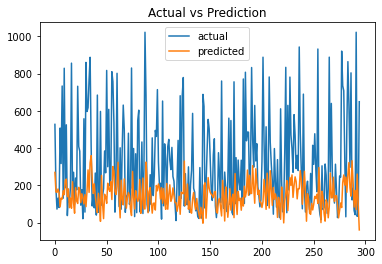

In [12]:
df.plot()

plt.title("Actual vs Prediction")
plt.legend()

plt.show()

In [13]:
percentage_error = tf.keras.losses.mean_absolute_percentage_error(df.actual, df.predicted).numpy()
accuracy = r2_score(df.actual, df.predicted)

print(f"Model MASE {percentage_error}\tModel Accuracy {accuracy}")

Model MASE 86.88293659559423	Model Accuracy -0.5716431083124092
